In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import random
from datetime import datetime, timedelta
from glob import glob
from tqdm import tqdm
from collections import Counter
import json
import os
from scipy.stats import mannwhitneyu,normaltest

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

**Data Decription**

*Experimental protocol*
- 17 subjects with different game experience: professional eSports players (pro) and common gamers (casual)
- data collected during gaming sessions lasting 30-50 minutes

*EEG recording acquisition*
- EEG data were recorded using the wireless EEG headset Emotiv Epoc+ from 14 usable saline electrodes according to the 10–20 system (AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4)  and 2 references on parietal sites (P3 and P4) \
    *for some reason, instead of O1, the Pz ​​channel was recorded

- the data stream from the headset represents automatically pre-filtered bands' power in time for 5 diffrent frequency bands:
  * theta (4-8Hz)
  * alpha (8-12Hz)
  * betaL (low beta, 12-16Hz)
  * betaH (high beta, 16-25Hz)
  * gamma (25-45Hz)
  
  The power values are absolute, the unit is uV^2 / Hz.

More specifically:\
The band power are calculated every ~0.2 seconds, using the last 2 seconds of EEG data.
The steps are:
1. High pass filter [5th order Sinc filter]
2. Remove DC offset (for each EEG channel, remove the mean value) [digital notch filters at 50Hz and 60Hz]
3. Hanning window
4. FFT
5. make the sum of the squares of the FFT values

# Data Preprosessing

Since the data undergoes built-in filtering and is already presented as frequency bands power, additional filtering is omitted.\
Preprocessing consists of resampling to a unified sampling rate, removing outliers and windowing.

## Load data

In [2]:
#load data for all subject
eeg_data = {int(os.path.basename(eeg_csv_file).split('_')[-1].replace('.csv','')):pd.read_csv(eeg_csv_file) for eeg_csv_file in glob('data/*.csv')}

#inspect data for missing values
for subject_num, df in eeg_data.items():
    print(subject_num,f'Number of NAN - {df.isna().sum().sum()}')

1 Number of NAN - 0
10 Number of NAN - 0
11 Number of NAN - 0
12 Number of NAN - 0
13 Number of NAN - 0
14 Number of NAN - 0
15 Number of NAN - 0
16 Number of NAN - 0
17 Number of NAN - 0
2 Number of NAN - 0
3 Number of NAN - 0
4 Number of NAN - 0
5 Number of NAN - 0
6 Number of NAN - 0
7 Number of NAN - 0
8 Number of NAN - 0
9 Number of NAN - 0


In [3]:
#look at data for one player
df = eeg_data[1]
df.head(3)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13332 entries, 0 to 13331
Data columns (total 85 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           13332 non-null  object 
 1   AF3_Q          13332 non-null  int64  
 2   AF3_Theta      13332 non-null  float64
 3   AF3_Alpha      13332 non-null  float64
 4   AF3_Low_beta   13332 non-null  float64
 5   AF3_High_beta  13332 non-null  float64
 6   AF3_Gamma      13332 non-null  float64
 7   F7_Q           13332 non-null  int64  
 8   F7_Theta       13332 non-null  float64
 9   F7_Alpha       13332 non-null  float64
 10  F7_Low_beta    13332 non-null  float64
 11  F7_High_beta   13332 non-null  float64
 12  F7_Gamma       13332 non-null  float64
 13  F3_Q           13332 non-null  int64  
 14  F3_Theta       13332 non-null  float64
 15  F3_Alpha       13332 non-null  float64
 16  F3_Low_beta    13332 non-null  float64
 17  F3_High_beta   13332 non-null  float64
 18  F3_Gam

In [4]:
#do some prelimenary preprocesing
#- remove unnecessary columns <CH_NAME>_Q
#- rename time column to unified view (as some csv files has 'Time' column name, some 'time')
#- convert time column from string (object) format to datetime
for subject_num,df in eeg_data.items():
     df = df.rename(columns={'Time': 'time'})
     df['time'] = df['time'].apply(datetime.fromisoformat)
     columns_to_del = [col for col in df.columns if col.endswith('_Q')]
     eeg_data[subject_num] = df.drop(columns_to_del, axis=1)

#and display dataframe once again
df = eeg_data[1]
display(df.head(3))

,time,AF3_Theta,AF3_Alpha,AF3_Low_beta,AF3_High_beta,AF3_Gamma,F7_Theta,F7_Alpha,F7_Low_beta,F7_High_beta,F7_Gamma,F3_Theta,F3_Alpha,F3_Low_beta,F3_High_beta,F3_Gamma,FC5_Theta,FC5_Alpha,FC5_Low_beta,FC5_High_beta,FC5_Gamma,T7_Theta,T7_Alpha,T7_Low_beta,T7_High_beta,T7_Gamma,P7_Theta,P7_Alpha,P7_Low_beta,P7_High_beta,P7_Gamma,Pz_Theta,Pz_Alpha,Pz_Low_beta,Pz_High_beta,Pz_Gamma,O2_Theta,O2_Alpha,O2_Low_beta,O2_High_beta,O2_Gamma,P8_Theta,P8_Alpha,P8_Low_beta,P8_High_beta,P8_Gamma,T8_Theta,T8_Alpha,T8_Low_beta,T8_High_beta,T8_Gamma,FC6_Theta,FC6_Alpha,FC6_Low_beta,FC6_High_beta,FC6_Gamma,F4_Theta,F4_Alpha,F4_Low_beta,F4_High_beta,F4_Gamma,F8_Theta,F8_Alpha,F8_Low_beta,F8_High_beta,F8_Gamma,AF4_Theta,AF4_Alpha,AF4_Low_beta,AF4_High_beta,AF4_Gamma
0,2018-12-05 15:21:53.456,88.81840,31.86970,16.738300,9.242950,3.775560,89.03300,31.96110,16.459100,8.951340,3.787820,120.0680,32.81050,18.48540,10.32410,3.922360,2.60624,1.146070,0.495772,0.300908,0.193570,4.97721,1.178080,5.00995,6.35518,2.46106,1.93398,0.427297,0.370892,0.333579,0.275346,6.51304,1.24491,0.803928,0.668288,0.232708,1.49562,1.022010,0.470642,0.547844,0.228207,12.8352,2.44676,1.64439,1.084370,0.338193,3.23034,1.60457,0.322741,1.034000,0.603393,2.23958,0.404941,0.321468,1.021890,0.408949,97.1256,16.0889,8.78671,7.49253,1.69110,2.67507,0.809096,0.455782,0.933581,0.431754,2.43432,0.915595,0.667310,0.934227,0.403769
1,2018-12-05 15:21:53.606,2.91398,2.45439,1.007510,0.639129,0.313605,3.97142,1.58841,0.732623,0.463573,0.402152,21.7518,3.37269,2.50003,2.35654,0.592251,2.70268,0.994118,0.429477,0.275830,0.179172,4.98538,1.032850,5.35241,6.20020,2.42866,2.23229,0.393328,0.377305,0.367726,0.268478,6.01487,1.18041,0.710280,0.623389,0.220564,1.58501,0.855149,0.462597,0.513925,0.249215,11.5439,2.17045,1.48795,1.043210,0.316501,3.53791,1.48562,0.450690,0.856996,0.604342,2.70636,0.288075,0.350479,0.823360,0.423788,88.4145,14.1018,7.91056,6.97971,1.54662,3.44649,0.677107,0.500876,0.794956,0.427042,2.80079,0.810531,0.604052,0.782021,0.375128
2,2018-12-05 15:21:53.757,2.72918,2.26093,0.895278,0.540243,0.284313,4.10502,1.51487,0.722728,0.433467,0.417493,17.7176,2.60250,2.16646,2.00187,0.493443,2.57817,0.808613,0.356522,0.241275,0.157609,4.67284,0.854782,5.26562,5.62496,2.35198,2.56605,0.381387,0.396634,0.390000,0.259642,4.99085,1.02108,0.582965,0.538047,0.204861,1.62435,0.723663,0.491550,0.455593,0.264798,9.1065,1.71205,1.19750,0.909723,0.267617,3.75571,1.35504,0.719646,0.684793,0.589536,3.22095,0.241466,0.439984,0.604768,0.430015,70.4399,10.8710,6.31897,5.70963,1.24578,4.24523,0.601678,0.604065,0.624602,0.414846,3.16812,0.700168,0.555879,0.607729,0.341824


In [5]:
#now we have 71 columns - 1 for time and 70 for channels: 14 diffrent channels x 5 freqency bands
print(f'\nShape: {eeg_data[subject_num].shape}')


Shape: (6854, 71)


In [6]:
#inspect eeg recored duration for all subjects
session_durations = []
for subject_num,df in eeg_data.items():
    td = (df.time.iloc[-1] - df.time.iloc[0])
    session_durations.append(td.total_seconds())
    print(subject_num,f'-\tRecord dration: {td}')

1 -	Record dration: 0 days 00:33:33.740000
10 -	Record dration: 0 days 00:31:41.616000
11 -	Record dration: 0 days 00:36:42.770000
12 -	Record dration: 0 days 00:25:37.153000
13 -	Record dration: 0 days 00:39:16.442000
14 -	Record dration: 0 days 00:33:19.494000
15 -	Record dration: 0 days 00:35:43.503000
16 -	Record dration: 0 days 00:41:06.993000
17 -	Record dration: 0 days 00:36:11.520000
2 -	Record dration: 0 days 00:28:36.655000
3 -	Record dration: 0 days 00:40:54.432000
4 -	Record dration: 0 days 00:21:36.897000
5 -	Record dration: 0 days 00:35:21.387000
6 -	Record dration: 0 days 00:32:28.716000
7 -	Record dration: 0 days 00:24:19.299000
8 -	Record dration: 0 days 00:33:06.921000
9 -	Record dration: 0 days 00:17:44.924000


Average eeg records duration: 32.2 minutes


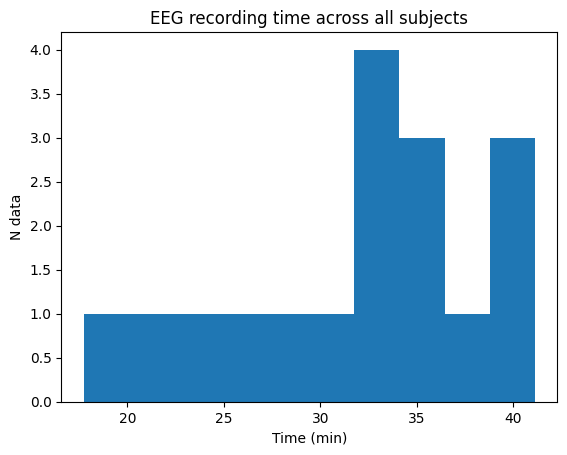

In [7]:
plt.hist(np.array(session_durations)/60)
plt.title('EEG recording time across all subjects')
plt.ylabel('N data')
plt.xlabel('Time (min)')
print(f'Average eeg records duration: {round(np.mean(session_durations)/60,1)} minutes')

## Sampling rate refinement

In [8]:
#look at data for one player once more
df = eeg_data[1]

#inspect eeg data recording intervals and compute sample frequency for this particular data
timedelta_df_description = pd.DataFrame((df['time'].values[1:]-df['time'].values[:-1]).astype(dtype='timedelta64[ms]').astype(int),columns=['timedelta (ms)'])\
        .describe().map('{:,.2f}'.format)
display(timedelta_df_description)

#it can be seen that the time intervals are uneven with the median value 150
print(f'Average Sample Rate: {round(1000/float(timedelta_df_description.loc['50%'].item()),3)} sample per second (sps)')

,timedelta (ms)
count,"13,331.00"
mean,151.06
std,6.46
min,142.00
25%,148.00
50%,150.00
75%,153.00
max,384.00


Average Sample Rate: 6.667 sample per second (sps)


Average Sample Rate across all data: 149.0 -- 6.711 sample per second (sps)


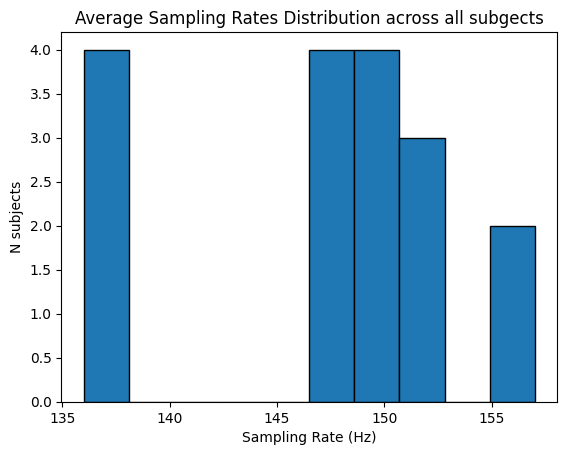

In [9]:
#let's look at data for all players
average_sampling_rates=[]
for df in eeg_data.values():
    average_sampling_rates.append(np.median((df['time'].values[1:]-df['time'].values[:-1]).astype(dtype='timedelta64[ms]').astype(int)))
    
plt.hist(np.array(average_sampling_rates),edgecolor='black');
plt.title('Average Sampling Rates Distribution across all subgects')
plt.xlabel('Sampling Rate (Hz)')
plt.ylabel('N subjects')
print(f'Average Sample Rate across all data: {np.median(average_sampling_rates)} -- {round(1000/np.median(average_sampling_rates),3)} sample per second (sps)')

In [10]:
#For further analysis, let's convert all data to have one sampling rate = 149 Hz 
sampling_rate = 149

for subject_num,df in eeg_data.items():
     df = df.set_index('time').resample(f'{sampling_rate}ms').mean().reset_index()
     eeg_data[subject_num] = df

## Outliers removal

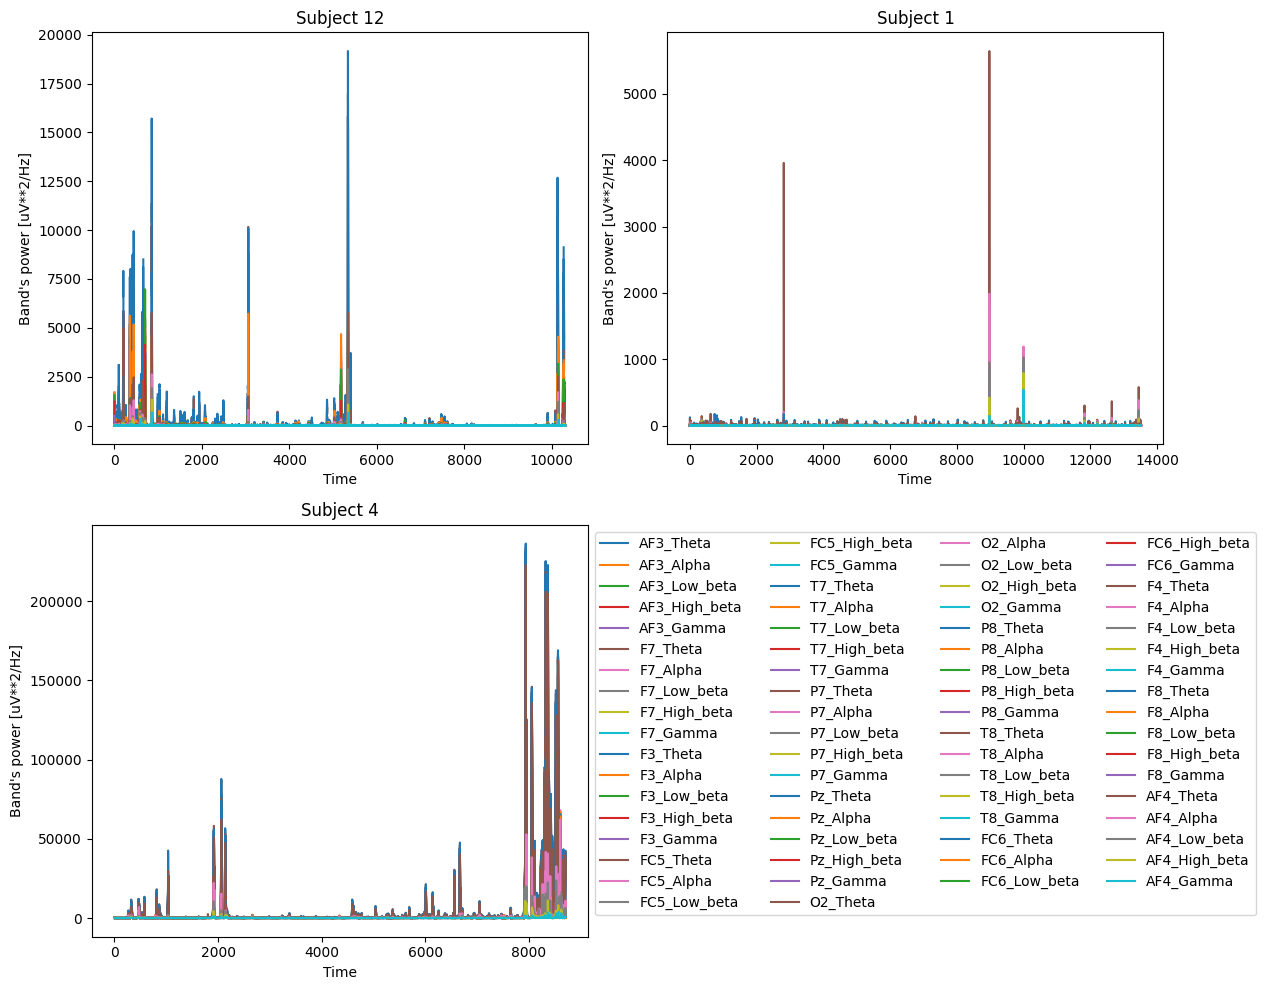

In [11]:
#let's look at some players' data once again and plot signal in time for all channels
random.seed(42)
selected_subject_ids = random.sample(list(eeg_data.keys()),k=3)

fig,axes = plt.subplots(2,2,figsize=(12,10))
axes = axes.ravel()
for sb_id,ax in zip(selected_subject_ids,axes):
    ax.set(xlabel='Time', ylabel="Band's power [uV**2/Hz]",title=f'Subject {sb_id}')
    df = eeg_data[sb_id]
    channel_columns = [col for col in df.columns if len(set.intersection(set(col.split('_')),set(['Theta', 'Alpha', 'beta', 'Gamma'])))>0]
    df[channel_columns].plot(ax=ax)
    ax.get_legend().remove()
    # plt.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=4);

fig.delaxes(axes[3])  # delete the empty subplot
fig.tight_layout()
plt.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=4);
plt.show()

it can be clearly seen that data contain strong **outliers** (which appeared due to the subject's movement, changing and shifting of the eeg headset, changes in physiological conditions, etc.)\
and that there are noticeable fluctuations at the beggining and at the end of the recordings

to deal with this:
1. let's cut 2 minutes from the beginning and from the end of recording (2 minutes was selected by manual investigation)
2. then apply the interquartile range (IQR) based method to detect the remaining outliers 
3. and replace them with interpolated values

In [12]:
def detect_outliers(df_in, col_name,coeff=1.5):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-coeff*iqr
    fence_high = q3+coeff*iqr
    return (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    

for subject_num,df in eeg_data.items():
    start_time = df.time.iloc[0] + timedelta(minutes=2)
    end_time =  df.time.iloc[-1] - timedelta(minutes=2)
    df = df.query('time>=@start_time and time <=@end_time').reset_index(drop=True)
    
    channel_columns = [col for col in df.columns if len(set.intersection(set(col.split('_')),set(['Theta', 'Alpha', 'beta', 'Gamma'])))>0]
    for ch in channel_columns:
        out_ids = detect_outliers(df,ch,coeff=3)
        df.loc[out_ids,ch] = None #replace outliers with None values
    df.interpolate(inplace=True) #interpolate None values (​​including those that appeared after resampling)
    if df.isna().sum().sum()>0: #deal with remaining None values at the beggining if any
        df = df.iloc[np.where(df.isna())[0].max()+1:][['time']+channel_columns].reset_index(drop=True)
    eeg_data[subject_num] = df

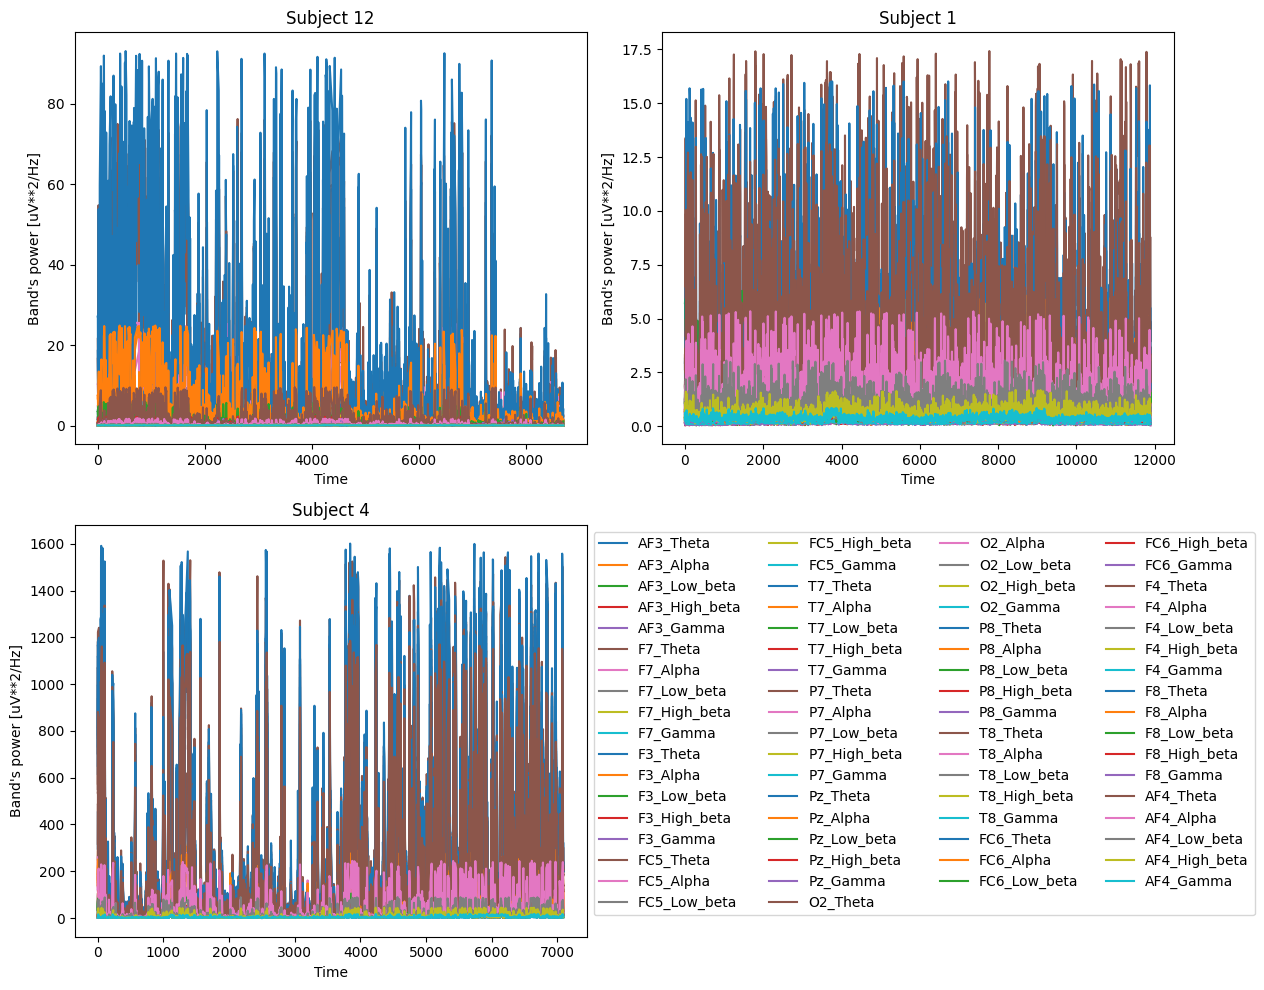

In [13]:
#plot the same players' data once again
fig,axes = plt.subplots(2,2,figsize=(12,10))
axes = axes.ravel()
for sb_id,ax in zip(selected_subject_ids,axes):
    ax.set(xlabel='Time', ylabel="Band's power [uV**2/Hz]",title=f'Subject {sb_id}')
    df = eeg_data[sb_id]
    channel_columns = [col for col in df.columns if len(set.intersection(set(col.split('_')),set(['Theta', 'Alpha', 'beta', 'Gamma'])))>0]
    df[channel_columns].plot(ax=ax)
    ax.get_legend().remove()
    # plt.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=4);

fig.delaxes(axes[3])  # delete the empty subplot
fig.tight_layout()
plt.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=4);
plt.show()

it can be seen that now most of the bands for most channels become visible and clearly distinguishable

## Windowing

Since the data represent frequency bands power values ​​over time for ~30 minutes, it is reasonable to divide a long time interval into shorter ones, for which various features are then calculated.\
According to existing works on eeg bands analysis in diffrent domains, typical intervals are from 1 to 5 minutes. Also, sometimes interval overlapping is used.

1 second:
* Smerdov, Anton & Somov, Andrey & Burnaev, Evgeny & Zhou, Bo & Lukowicz, Paul. (2021). Detecting Video Game Player Burnout With the Use of Sensor Data and Machine Learning. IEEE Internet of Things Journal. 8. 16680-16691. 10.1109/JIOT.2021.3074740. 
* Fellrath, Julia & Mottaz, Anaïs & Schnider, Armin & Guggisberg, Adrian & Ptak, Radek. (2016). Theta-band functional connectivity in the dorsal fronto-parietal network predicts goal-directed attention. Neuropsychologia. 92. 10.1016/j.neuropsychologia.2016.07.012. 
* Puszta, András & Katona, Xénia & Bodosi, Balázs & Pertich, Ákos & Nyujtó, Diána & Braunitzer, Gabor & Nagy, Attila. (2018). Cortical Power-Density Changes of Different Frequency Bands in Visually Guided Associative Learning: A Human EEG-Study. Frontiers in Human Neuroscience. 12. 10.3389/fnhum.2018.00188.

2 seconds:
* Melentev, Nikita & Somov, Andrey & Burnaev, Evgeny & Strelnikova, Irina & Strelnikova, Galina & Melenteva, Elizaveta & Menshchikov, Alexander. (2020). eSports Players Professional Level and Tiredness Prediction using EEG and Machine Learning. 1-4. 10.1109/SENSORS47125.2020.9278704. 
* Minchev, Zlatogor & Dukov, Georgi & Georgiev, Stiliyan. (2009). EEG Spectral Analysis in Serious Gaming: An Ad Hoc Experimental Application. International Journal Bioautomation. 13.

3 seconds:
* Diaz, Hernan & Gárate, Elías & Maureira Cid, Fernando & Flores Ferro, Elizabeth. (2022). Hurst entropy profiles for Beta Low and Beta High EEG sub-bands Part I: Intragroup comparison.. Procedia Computer Science. 199. 1416-1423. 10.1016/j.procs.2022.01.179. 

4 seconds:
* Aldayel, Mashael & Ykhlef, Mourad & Alnafjan, Abeer. (2021). Recognition of Consumer Preference by Analysis and Classification EEG Signals. Frontiers in Human Neuroscience. 14. 10.3389/fnhum.2020.604639. 

5 seconds: 
* Mateos, Diego & Krumm, Gabriela & Filippetti, Vanessa & Gutierrez, Marisel. (2022). Power Spectrum and Connectivity Analysis in EEG Recording during Attention and Creativity Performance in Children. NeuroSci. 3. 347-365. 10.3390/neurosci3020025. 

Thus, let's create a windowing function with the overlapping option

In [14]:
def do_windowing(df,
                 sampling_rate,
                 window_size = 2, #in seconds
                 overlap = 0,     #persentage
                ):
    splitted_data = []
    all_samples = 0
    skipped_samples = 0
    min_len_thresh = int(window_size*1000/sampling_rate) #minimum acceptable threshold for sample size (in case of time gaps)
    channel_columns = [col for col in df.columns if len(set.intersection(set(col.split('_')),set(['Theta', 'Alpha', 'beta', 'Gamma'])))>0]
    start_time = df['time'].iloc[0]
    while start_time<=df['time'].iloc[-1]:
        end_time = start_time + timedelta(seconds=window_size)
        all_samples+=1
        sub_df = df.query('time>=@start_time and time<=@end_time')[channel_columns]
        if sub_df.shape[0]>=min_len_thresh:
            splitted_data.append(sub_df.values.T[:,:min_len_thresh])
        else:
            skipped_samples+=1
        start_time = start_time + timedelta(seconds=window_size) - timedelta(seconds=window_size*overlap)
    print(f'END: skipped {skipped_samples}\tall {all_samples}\n')
    return np.stack(splitted_data)

In [15]:
#try diffrent options and see the number of obtained samples
df = eeg_data[5]
for window_size,overlap in zip([1,2,2,2,2,3,3],[0,0,0.3,0.5,0.7,0,0.5]):
    print('=======')
    new_data = do_windowing(df,
                   sampling_rate=sampling_rate,
                   window_size = window_size,
                   overlap = overlap)
    print(f'Option: window_size = {window_size}, overlap = {overlap} \t {new_data.shape}') #new_data.shape - (n_samples,n_channels, n_points_in_sample)

END: skipped 1	all 1882

Option: window_size = 1, overlap = 0 	 (1881, 70, 6)
END: skipped 1	all 941

Option: window_size = 2, overlap = 0 	 (940, 70, 13)
END: skipped 1	all 1344

Option: window_size = 2, overlap = 0.3 	 (1343, 70, 13)
END: skipped 2	all 1882

Option: window_size = 2, overlap = 0.5 	 (1880, 70, 13)
END: skipped 3	all 3136

Option: window_size = 2, overlap = 0.7 	 (3133, 70, 13)
END: skipped 1	all 628

Option: window_size = 3, overlap = 0 	 (627, 70, 20)
END: skipped 2	all 1255

Option: window_size = 3, overlap = 0.5 	 (1253, 70, 20)


for further analysis let's use (window_size = 2, overlap = 0) option for now (later other option will be tested)

# Exploratory data analysis (EDA)

## Labels loading  

In [16]:
#load subject - label mapping
with open('data/label_dict.json') as file:
    label_markup = json.load(file)
label_markup,Counter(label_markup.values())

({'1': 'casual',
  '2': 'casual',
  '3': 'casual',
  '4': 'casual',
  '5': 'casual',
  '6': 'casual',
  '7': 'casual',
  '8': 'casual',
  '9': 'casual',
  '10': 'casual',
  '11': 'casual',
  '12': 'casual',
  '13': 'casual',
  '14': 'pro',
  '15': 'pro',
  '16': 'pro',
  '17': 'pro'},
 Counter({'casual': 13, 'pro': 4}))

The dataset include:
* 4 - professional eSports players (pro) with the highest game proficiency
* 13 - common gamers (casual) 

## The dependence of the average bands' power on the player skill

In [17]:
#just get channel_columns
channel_columns = [col for col in eeg_data[3].columns if len(set.intersection(set(col.split('_')),set(['Theta', 'Alpha', 'beta', 'Gamma'])))>0]

#get average power for all 70 rythm-channel columns for each 2 seconds interval
df_stat = pd.DataFrame(columns=['label']+channel_columns)
for subject_num,df in eeg_data.items():
    label = label_markup[str(subject_num)]
    cur_df = pd.DataFrame(columns=['label']+channel_columns)
    cur_df[channel_columns] = np.median(do_windowing(df,sampling_rate=sampling_rate),axis=2)
    cur_df['label'] = label
    df_stat = pd.concat([df_stat,cur_df])

END: skipped 0	all 886



C:\Users\Jull\AppData\Local\Temp\ipykernel_8108\982354732.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_stat = pd.concat([df_stat,cur_df])


END: skipped 1	all 831

END: skipped 1	all 982

END: skipped 1	all 649

END: skipped 1	all 1059

END: skipped 1	all 880

END: skipped 1	all 908

END: skipped 0	all 1112

END: skipped 1	all 966

END: skipped 1	all 739

END: skipped 1	all 1108

END: skipped 1	all 529

END: skipped 1	all 941

END: skipped 1	all 854

END: skipped 1	all 606

END: skipped 1	all 874

END: skipped 1	all 411



Let's first conduct check the power value distributions for normality in order to choose the right statistical test for between group comparison

In [18]:
for ch_band_name in channel_columns:
    p_val_pro = normaltest(df_stat.query('label=="pro"')[ch_band_name].values).pvalue
    p_val_cas = normaltest(df_stat.query('label=="casual"')[ch_band_name].values).pvalue
    print(ch_band_name+':\t pro_p_val {:.3g} \t casual_p_val {:.3g}'.format(p_val_pro,p_val_cas))

AF3_Theta:	 pro_p_val 0 	 casual_p_val 0
AF3_Alpha:	 pro_p_val 0 	 casual_p_val 0
AF3_Low_beta:	 pro_p_val 0 	 casual_p_val 0
AF3_High_beta:	 pro_p_val 1.4e-276 	 casual_p_val 0
AF3_Gamma:	 pro_p_val 7.37e-249 	 casual_p_val 0
F7_Theta:	 pro_p_val 0 	 casual_p_val 0
F7_Alpha:	 pro_p_val 0 	 casual_p_val 0
F7_Low_beta:	 pro_p_val 0 	 casual_p_val 0
F7_High_beta:	 pro_p_val 1.04e-292 	 casual_p_val 0
F7_Gamma:	 pro_p_val 2.17e-293 	 casual_p_val 0
F3_Theta:	 pro_p_val 0 	 casual_p_val 0
F3_Alpha:	 pro_p_val 0 	 casual_p_val 0
F3_Low_beta:	 pro_p_val 0 	 casual_p_val 0
F3_High_beta:	 pro_p_val 9.29e-286 	 casual_p_val 0
F3_Gamma:	 pro_p_val 1.62e-204 	 casual_p_val 0
FC5_Theta:	 pro_p_val 0 	 casual_p_val 0
FC5_Alpha:	 pro_p_val 0 	 casual_p_val 0
FC5_Low_beta:	 pro_p_val 0 	 casual_p_val 0
FC5_High_beta:	 pro_p_val 1.54e-194 	 casual_p_val 0
FC5_Gamma:	 pro_p_val 2.84e-196 	 casual_p_val 0
T7_Theta:	 pro_p_val 0 	 casual_p_val 0
T7_Alpha:	 pro_p_val 0 	 casual_p_val 0
T7_Low_beta:	 pro_p

it is clearly seen that power value distributions for all band-channel columns are not normal. Thus let's use nonparametric Mann-Whitney test for pair-wise comparison

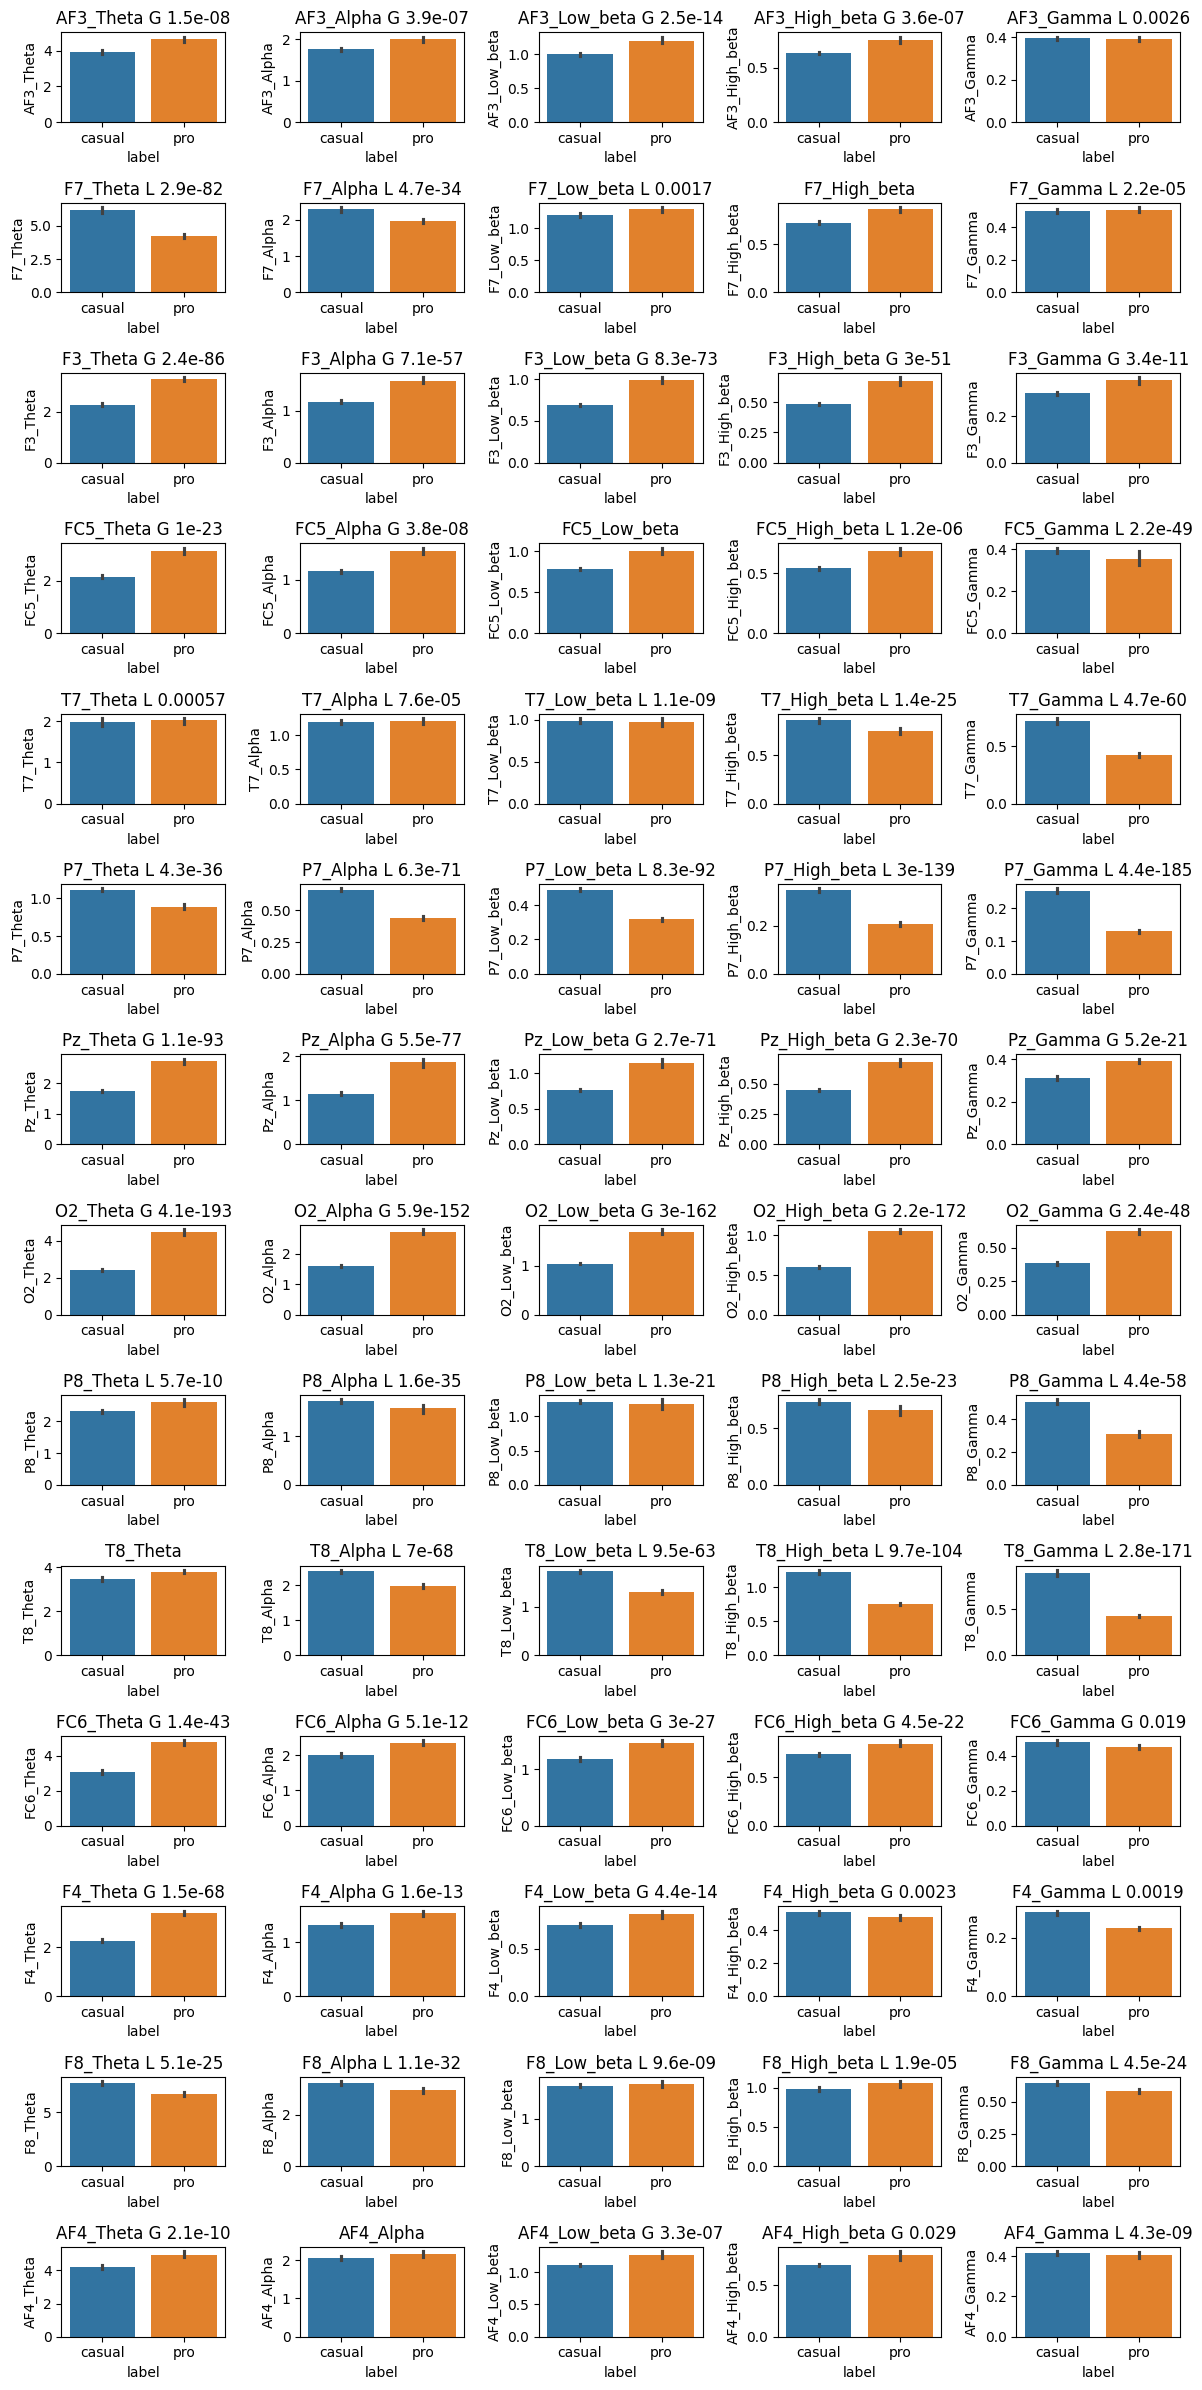

In [19]:
fig,axes = plt.subplots(14,5,figsize=(12,24))
axes = axes.ravel()
for ch_band_name,ax in zip(channel_columns,axes):
    p_val_g = mannwhitneyu(list(df_stat.groupby('label')[ch_band_name])[1][1].values,list(df_stat.groupby('label')[ch_band_name])[0][1].values,alternative='greater').pvalue
    p_val_l = mannwhitneyu(list(df_stat.groupby('label')[ch_band_name])[1][1].values,list(df_stat.groupby('label')[ch_band_name])[0][1].values,alternative='less').pvalue
    p_val = 1
    if p_val_g<0.05:
        ax.set(title=ch_band_name+' G {:.2g}'.format(p_val_g))
    elif p_val_l<0.05:
        ax.set(title=ch_band_name+' L {:.2g}'.format(p_val_l))
    else:
        ax.set(title=ch_band_name)
    sns.barplot(data=df_stat,x='label',y=ch_band_name,ax=ax,hue='label',estimator='median')
fig.tight_layout()

it can be seen that there is statistical significance between the groups in most channels - this means that the features built on their basis are expected to be meaningful and the eeg- bands based classification is possible in general

* In more detail, it can be noted that in channel O2 for all rhythms the values ​​are significantly higher for professionals, compared to casual players. This can be explained by the fact that O2 is located in the occipital lobe and is responsible for processing visual information and transmitting processed data to other brain areas. And for professionals, this area works better during the game due to their extensive experience.
* The theta rhythm in most channels is higher for professionals, which corresponds to the results of works [1] and [2] and is explained by the fact that professionals are more focused on the upcoming tasks.
* It can also be noted that for the area of ​​the temporal cortex (T7, P7, T8, P8), the values ​​of almost all rhythms (except theta) are higher for casual players. Considering that the temporal cortex is responsible for processing auditory signals, it can be assumed that pro players are more focused (theta rhythm) and less distracted by extraneous noises and game sounds compared to regular players, who are more entertained and engaged in the game.
* The values ​​in the Pz channel for all rhythms are significantly higher for pro players. Since the parietal cortex area is responsible for motor functions, it can be assumed that for pro players the increased values ​​are associated with their skills and experience.

[1] Melentev, Nikita & Somov, Andrey & Burnaev, Evgeny & Strelnikova, Irina & Strelnikova, Galina & Melenteva, Elizaveta & Menshchikov, Alexander. (2020). eSports Players Professional Level and Tiredness Prediction using EEG and Machine Learning. 1-4. 10.1109/SENSORS47125.2020.9278704.\
[2] M. Doppelmayr, T. Finkenzeller, and P. Sauseng, "Frontal midline theta in the pre-shot phase of rifle shooting: Differences between experts and novices," Neuropsychologia, vol. 46, pp. 1463–7, 05 2008.